<a href="https://colab.research.google.com/github/zaid478/MSDS19006_COVID19_DLSpring2020/blob/master/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.nn.functional import one_hot,sigmoid,binary_cross_entropy_with_logits
from sklearn.metrics import multilabel_confusion_matrix

In [0]:
!unzip "/content/drive/My Drive/Copy_of_A_05_Part_02_Dataset.zip" -d "/content/drive/My Drive"

In [2]:
!gdown https://drive.google.com/uc?id=1Tgp5JhxrFty_jlI6qBlqpDo6O0CCYMSv

Downloading...
From: https://drive.google.com/uc?id=1Tgp5JhxrFty_jlI6qBlqpDo6O0CCYMSv
To: /content/Copy_of_A_05_Part_02_Dataset.zip
3.00GB [00:44, 66.9MB/s]


In [0]:
!unzip /content/Copy_of_A_05_Part_02_Dataset.zip

In [0]:
!mkdir /content/A_05_Part_02_Dataset/Test/sub_test

In [0]:
!mv /content/A_05_Part_02_Dataset/Test/*.jpg /content/A_05_Part_02_Dataset/Test/sub_test/

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [0]:
data_dir = '/content/A_05_Part_02_Dataset'
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)
testing_data = ImageFolderWithPaths(data_dir + '/Test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers= 4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers= 4)
testingloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=True, num_workers= 4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

In [17]:
len(testing_data)

629

In [0]:
len(train_data),len(test_data)

(6200, 628)

In [0]:
def make_multiple_hot(labels):
  one_hot_encodings = torch.zeros((len(labels),3))
  for index_ in range(len(one_hot_encodings)):
    if (labels[index_] == 0):
      one_hot_encodings[index_,0] = 1
      one_hot_encodings[index_,2] = 1
    elif (labels[index_] == 1):
      one_hot_encodings[index_,1] = 1
    else:
      one_hot_encodings[index_,2] = 1
  
  return one_hot_encodings

In [0]:
def threshold(scores):
  for index,sc in enumerate(scores):
    if sc >= 0.5:
      scores[index] = 1

    else:
      scores[index] = 0
  return scores

In [0]:
def accuracy(labels,labels_model):
  n_ = 0
  for i,j in zip(labels,labels_model):
    label_ = (i == 1).nonzero()
    label_mod = (j == 1).nonzero()
    # print (label_,label_mod)
    sc = len(np.intersect1d(label_,label_mod))/len(np.union1d(label_,label_mod))
    n_ += sc
  return n_

In [0]:
def train_model(model_,epochs,optimizer,model_dir,model_name,type_):


  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print (device)
  model_.to(device)
  # sig_layer = nn.Sigmoid()

  best_loss = 10000
  # criterion = nn.BCEWithLogitsLoss()
  losses_train,losses_valid,accuracy_train,accuracy_valid = [],[],[],[]
  for epoch in range(epochs):  # loop over the dataset multiple times

      model_.train(True)
      running_loss = 0.0
      running_corrects = 0 
      print ("Training")
      batch = 0
      for inputs,labels in trainloader: 
          inputs,labels = inputs.to(device), labels.to(device)
          labels = make_multiple_hot(labels)
          print (batch)
          batch += 1
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_(inputs)               #----> forward pass
          # print (outputs)
          labels = labels.type_as(outputs)
          loss = focal_loss(outputs, labels,0.25,2)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update
          scores = sigmoid(outputs)
          # print (scores)
          labels_model = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())
          running_loss += loss.item()

          acc_ = accuracy(labels.cpu().numpy(),labels_model)
          running_corrects += acc_
      epoch_loss = running_loss / len(train_data)
      epoch_acc = running_corrects /len(train_data)
      losses_train.append(epoch_loss)
      accuracy_train.append(epoch_acc)


      model_.eval()
      running_loss = 0.0
      running_corrects = 0
      print ("Validation")
      batch = 0
      for inputs,labels in testloader:
        inputs,labels = inputs.to(device),labels.to(device)
        labels = make_multiple_hot(labels)        
        output_val = model_(inputs)
        labels = labels.type_as(outputs)
        loss = focal_loss(output_val, labels,0.25,2)
        scores = sigmoid(output_val)
        # print (scores)
        labels_model = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())
        print (batch)
        batch += 1
        running_loss += loss.item()
        acc_ = accuracy(labels.cpu().numpy(),labels_model)
        running_corrects += acc_


      epoch_loss_valid = running_loss/len(test_data)
      epoch_acc_valid = running_corrects/len(test_data)
      losses_valid.append(epoch_loss_valid)
      accuracy_valid.append(epoch_acc_valid)

      print ("Epoch {}".format(epoch))
      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Training', epoch_loss, epoch_acc))
      print('{} Loss: {:.4f} Acc: {:.4f}'.format('Validation', epoch_loss_valid, epoch_acc_valid))

      if (epoch_loss < best_loss):
        print ("saving")
        torch.save(model_, model_dir+model_name+'_'+type_+'.pth')
      np.save(model_dir+model_name+'_'+type_+"metrics.txt",[losses_train,losses_valid,accuracy_train,accuracy_valid])



  print('Finished Training')

### Task 1 a) VGG 16 without focal loss 

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
num_features = 25088

vgg16.classifier = nn.Sequential(*[nn.Linear(num_features,1024), nn.ReLU(), nn.Linear(1024,3)])

In [0]:
Epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"

train_model(vgg16,criterion,Epochs,optimizer,model_dir,"vgg16","without_focal")

In [0]:
metrics_ = np.load(model_dir+"vgg16_without_focalmetrics.txt.npy")

In [0]:
losses_train,losses_valid,accuracy_train,accuracy_valid = metrics_[0],metrics_[1],metrics_[2],metrics_[3]

Text(0.5, 0, 'Epochs')

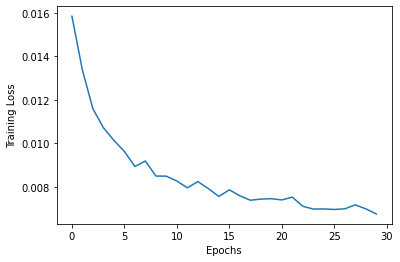

In [0]:
plt.plot(losses_train)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

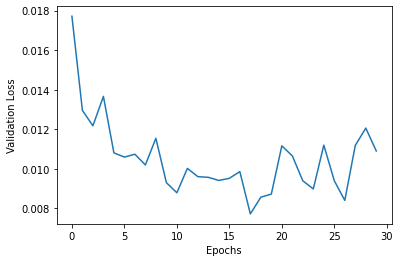

In [0]:
plt.plot(losses_valid)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

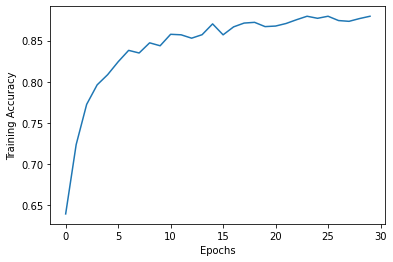

In [0]:
plt.plot(accuracy_train)
plt.ylabel("Training Accuracy")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

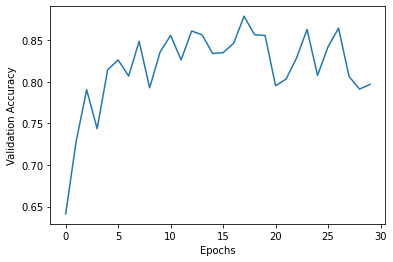

In [0]:
plt.plot(accuracy_valid)
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")

#### Confusion Matrix

In [15]:
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"
vgg16 = torch.load(model_dir+"vgg16_without_focal.pth")
# nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels_model = np.empty((0,3), int)
labels_true = np.empty((0,3), int)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        print (i)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = make_multiple_hot(labels)

        outputs = vgg16(inputs)
        scores = sigmoid(outputs)
        # print (scores)
        labels_mod = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())

        labels_true = np.append(labels_true,labels,axis=0)
        labels_model = np.append(labels_model,labels_mod,axis=0)
        # print (labels_model.shape)




print(multilabel_confusion_matrix(labels_true,labels_model))

[[[600   0]
  [ 28   0]]

 [[188  40]
  [ 69 331]]

 [[333  67]
  [ 40 188]]]


### Task 1 b) ResNet 18 without focal loss

In [0]:
res18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
num_features = res18.fc.in_features
res18.fc = nn.Sequential(*[nn.Linear(num_features,256), nn.ReLU(), nn.Linear(256,3)])

In [0]:
Epochs = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(res18.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"

train_model(res18,criterion,Epochs,optimizer,model_dir,"res18","without_focal")

In [0]:
metrics_ = np.load(model_dir+"res18_without_focalmetrics.txt.npy")
losses_train,losses_valid,accuracy_train,accuracy_valid = metrics_[0],metrics_[1],metrics_[2],metrics_[3]

Text(0.5, 0, 'Epochs')

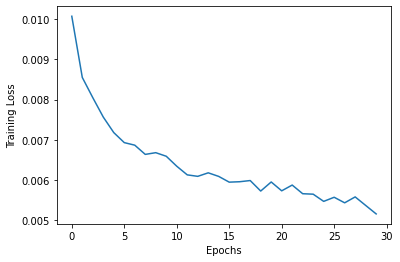

In [0]:
plt.plot(losses_train)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

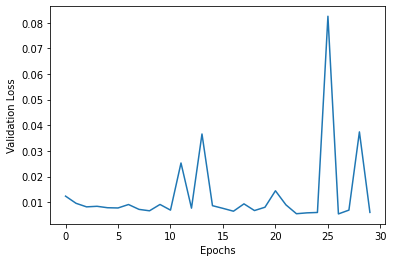

In [0]:
plt.plot(losses_valid)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

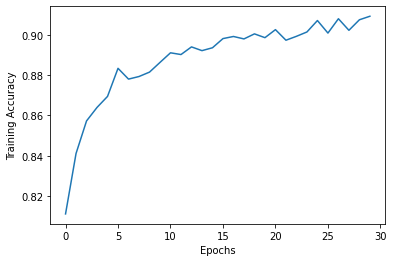

In [0]:
plt.plot(accuracy_train)
plt.ylabel("Training Accuracy")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

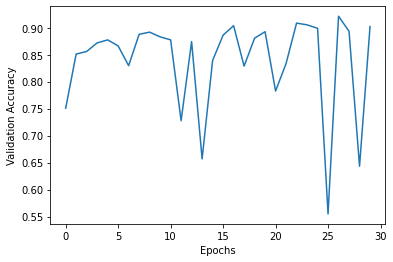

In [0]:
plt.plot(accuracy_valid)
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")

In [17]:
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"
res18 = torch.load(model_dir+"res18_without_focal.pth")
# nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels_model = np.empty((0,3), int)
labels_true = np.empty((0,3), int)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        print (i)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = make_multiple_hot(labels)

        outputs = res18(inputs)
        scores = sigmoid(outputs)
        # print (scores)
        labels_mod = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())

        labels_true = np.append(labels_true,labels,axis=0)
        labels_model = np.append(labels_model,labels_mod,axis=0)
        # print (labels_model.shape)




print(multilabel_confusion_matrix(labels_true,labels_model))

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1
2
3
4
5
6
7
8
9
[[[595   5]
  [ 16  12]]

 [[196  32]
  [ 20 380]]

 [[380  20]
  [ 32 196]]]


In [0]:
def focal_loss(model_output,target,alpha,gamma):


  logpt = - binary_cross_entropy_with_logits(model_output, target, reduction='sum')
  pt = torch.exp(logpt)

   # compute the loss
  focal_loss = -( (1-pt)**gamma ) * logpt * alpha

  return focal_loss

### Task 2 a) VGG 16 with focal loss

In [0]:
Epochs = 30
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"

train_model(vgg16,Epochs,optimizer,model_dir,"vgg16","with_focal")

In [0]:
metrics_ = np.load("/content/drive/My Drive/model_pytorch/assignment_5b/vgg16_with_focalmetrics.txt.npy")
losses_train,losses_valid,accuracy_train,accuracy_valid = metrics_[0],metrics_[1],metrics_[2],metrics_[3]

Text(0.5, 0, 'Epochs')

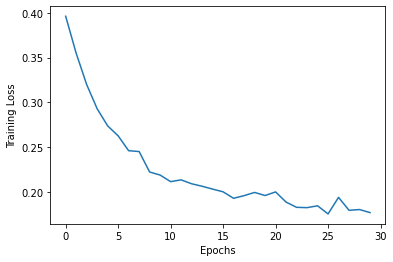

In [0]:
plt.plot(losses_train)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

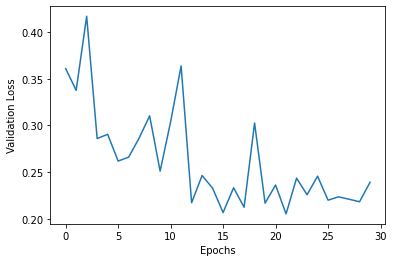

In [0]:
plt.plot(losses_valid)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

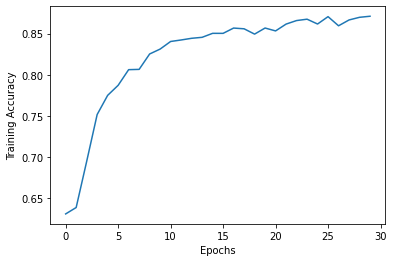

In [0]:
plt.plot(accuracy_train)
plt.ylabel("Training Accuracy")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

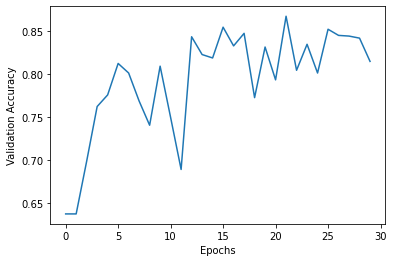

In [0]:
plt.plot(accuracy_valid)
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")

In [18]:
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"
vgg16 = torch.load(model_dir+"vgg16_with_focal.pth")
# nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels_model = np.empty((0,3), int)
labels_true = np.empty((0,3), int)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        print (i)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = make_multiple_hot(labels)

        outputs = vgg16(inputs)
        scores = sigmoid(outputs)
        # print (scores)
        labels_mod = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())

        labels_true = np.append(labels_true,labels,axis=0)
        labels_model = np.append(labels_model,labels_mod,axis=0)
        # print (labels_model.shape)




print(multilabel_confusion_matrix(labels_true,labels_model))

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1
2
3
4
5
6
7
8
9
[[[600   0]
  [ 28   0]]

 [[190  38]
  [ 61 339]]

 [[339  61]
  [ 38 190]]]


### Task 2 a) ResNet 18 with focal loss

In [0]:
Epochs = 30
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(res18.parameters(), lr=0.001)
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"

train_model(res18,Epochs,optimizer,model_dir,"res18","with_focal")

In [0]:
metrics_ = np.load("/content/drive/My Drive/model_pytorch/assignment_5b/res18_with_focalmetrics.txt.npy")
losses_train,losses_valid,accuracy_train,accuracy_valid = metrics_[0],metrics_[1],metrics_[2],metrics_[3]

Text(0.5, 0, 'Epochs')

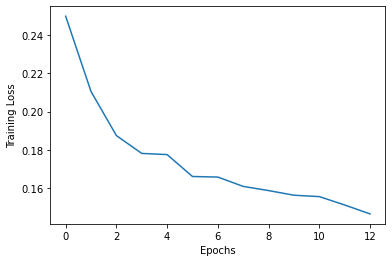

In [0]:
plt.plot(losses_train)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

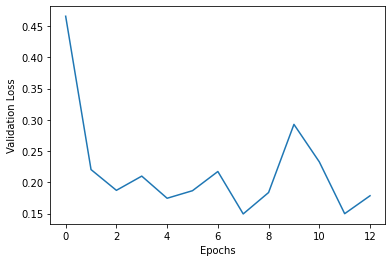

In [0]:
plt.plot(losses_valid)
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

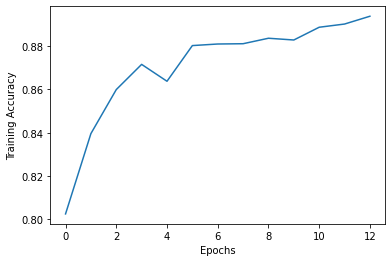

In [0]:
plt.plot(accuracy_train)
plt.ylabel("Training Accuracy")
plt.xlabel("Epochs")

Text(0.5, 0, 'Epochs')

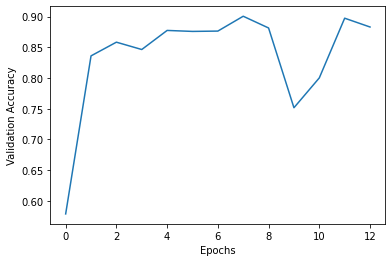

In [0]:
plt.plot(accuracy_valid)
plt.ylabel("Validation Accuracy")
plt.xlabel("Epochs")

In [19]:
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"
res18 = torch.load(model_dir+"res18_with_focal.pth")
# nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels_model = np.empty((0,3), int)
labels_true = np.empty((0,3), int)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        print (i)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels = make_multiple_hot(labels)

        outputs = res18(inputs)
        scores = sigmoid(outputs)
        # print (scores)
        labels_mod = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())

        labels_true = np.append(labels_true,labels,axis=0)
        labels_model = np.append(labels_model,labels_mod,axis=0)
        # print (labels_model.shape)




print(multilabel_confusion_matrix(labels_true,labels_model))

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1
2
3
4
5
6
7
8
9
[[[592   8]
  [ 24   4]]

 [[196  32]
  [ 46 354]]

 [[355  45]
  [ 32 196]]]


### Predictions on Test set

In [0]:
model_dir = "/content/drive/My Drive/model_pytorch/assignment_5b/"
res18 = torch.load(model_dir+"res18_without_focal.pth")
# nb_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
labels_model = np.empty((0,3), int)
paths = []
with torch.no_grad():
    for i, (inputs, labels,path) in enumerate(testingloader):
        print (i)
        inputs = inputs.to(device)

        outputs = res18(inputs)
        scores = sigmoid(outputs)
        print (path)
        paths.append(path)
        labels_mod = np.apply_along_axis(threshold, 1, scores.detach().cpu().numpy())

        labels_model = np.append(labels_model,labels_mod,axis=0)
        # print (labels_model.shape)




# print(multilabel_confusion_matrix(labels_true,labels_model))

In [0]:
flat_list = [item for sublist in paths for item in sublist]

In [0]:
images_names = []
for name_image in flat_list:
  images_names.append(name_image.split('/')[-1])

In [0]:
results = pd.DataFrame({'name':images_names,'covid':labels_model[:,0],'pneumonia':labels_model[:,2],'normal':labels_model[:,1]})

In [0]:
results.to_csv("/content/drive/My Drive/model_pytorch/assignment_5b/results.csv")